# DNA Assemblies, gene expression, transcription, and translation
The central Dogma - namely that DNA is transcribed to mRNA which is translated to proteins - is a key part of modelling many biochemical processes, especially in synthetic biology. Towards enabling easy modeling of transcription and translation in diverse context, BioCRNpyler has a number of Mixtures, Components and Mechanisms to produce models which include the central dogma.

# Example 1: Creating a DNAassembly
DNAassembly is a Component consisting of 2 sub Components: Promoter and RBS (ribosome binding site). DNAassembly automatically produces transcription and translation reactions from simple specifications: a DNAassembly X will produce 3 species dna_X, rna_X, and protein_X. These species can also be renamed manually if desired.

In [1]:
from biocrnpyler.core import Mixture
from biocrnpyler.components.dna import DNAassembly
from biocrnpyler.mechanisms import SimpleTranscription, SimpleTranslation

#promoter is the name of the promoter or a Promoter component
#RBS is the name of the RBS or an RBS Component
#   RBS = None means there will be no translation
#By default (if transcript and protein are None), the transgript and protein will have the same name as an assmebly
#   Users can also assign Species or String names to transcript and protein
G = DNAassembly("X", promoter = "P", rbs = "RBS", transcript = None, protein = None)

#create a transcription and translation Mechanisms. 
mech_tx = SimpleTranscription()
mech_tl = SimpleTranslation()

#place that mechanism in a dictionary: {"transcription":mech_tx, "translation":mech_tl}
default_mechanisms = {mech_tx.mechanism_type:mech_tx, mech_tl.mechanism_type:mech_tl}

#Use default parameters for conviencience
default_parameters = {"kb":100, "ku":10, "ktx":.5, "ktl":2}
#Create a mixture.
M = Mixture("Catalysis Mixture", components = [G], parameters = default_parameters, mechanisms = default_mechanisms)
    
print("repr(Mixture) gives a printout of what is in a mixture and what it's Mechanisms are:\n", repr(M),"\n")

#Compile the CRN with Mixture.compile_crn
CRN = M.compile_crn()

print("Pretty_print representation of the CRN:\n",
      CRN.pretty_print(show_rates = True, show_attributes = True, show_materials = True))

repr(Mixture) gives a printout of what is in a mixture and what it's Mechanisms are:
 Mixture: Catalysis Mixture
Components = [
	DNAassembly: X ]
Mechanisms = {
	transcription:simple_transcription
	translation:simple_translation } 

Pretty_print representation of the CRN:
 Species(N = 3) = {
protein[X] (@ 0),  rna[X] (@ 0),  dna[X] (@ 0),  
}

Reactions (2) = [
0. dna[X] --> dna[X]+rna[X]
 Kf=k_forward * dna_X
  k_forward=0.5
  found_key=(mech=None, partid=None, name=ktx).
  search_key=(mech=simple_transcription, partid=P, name=ktx).

1. rna[X] --> rna[X]+protein[X]
 Kf=k_forward * rna_X
  k_forward=2
  found_key=(mech=None, partid=None, name=ktl).
  search_key=(mech=simple_translation, partid=RBS, name=ktl).

]


# Example 2: Placing a DNAassmebly in different Cell-like Mixtures for Transcription and Translation
BioCRNpyler contains many pre-built Mixtures to model Transcription and Translation at different levels of detail in different contexts. Cell-like Mixtures are designed to more accurately model the internal environment of a cell.

## Cell-Like Mixtures:
__ExpressionDilutionMixture__ uses the Mechanisms: OneStepGeneExpression
* Genes express in a single step $G \to G + P_G$. 
* Proteins are degraded: $P_G \to \emptyset$.

__SimpleTxTlDilutionMixture__ uses the Mechanisms: SimpleTranscription, SimpleTranslation, and Dilution (A global Mechanisms)
* Genes transcribe via simple catalysis $G_X \to G_X + T_X$
* mRNAs translate via simple catalyis $T_X \to T_X + P_X$. 
* Proteins and mRNA are degraded/diluted at different rates: $T_X \to \emptyset$, $P_X \to \emptyset$.

__TxTlDilutionMixture__ uses the Mechanisms: Transcription_MM, Translation_MM, Degredation_mRNA_MM and Dilution (A global Mechanisms)
* Genes transcribe via RNApolymerase (RNAP) $G_X + RNAP \rightleftarrows G_X:RNAP \to G_X + RNAP + T_X$
* mRNAs translate via Ribosomes (Ribo) $T_X + Ribo \rightleftarrows T_X:Ribo \to T_X + Ribo + P_X$
* mRNAs are degraded via endonucleases (Endo): $T_X + Endo \rightleftarrows T_X:Endo \to Endo$
* Proteins & mRNA are Diluted: $P_X \to \emptyset$, $T_X \to \emptyset$
* A Background DNAassembly $G_{\text{cellular\_processes}}$ puts loading on all the cellular resources.

In the following examples, the parameter file default_parameters.txt will be used to quickly produce more complex models with realistic parameters.

In [2]:
from biocrnpyler.mixtures import ExpressionDilutionMixture, SimpleTxTlDilutionMixture, TxTlDilutionMixture
#Changing the promoter and RBS name will result in different parameters
#Here are some parameters loaded into default_parameters.txt
#Promoter Names: strong, medium, weak correspond to bicistronic RBSs: BCD2, BCD8 and BCD12
#RBS Names: strong, medium, Weak correspond to Anderson Promoters: J23100, J23106, and J23103
G = DNAassembly("X", promoter = "strong", rbs = "weak", transcript = None, protein = None)
#Also notice that the names of transcript and protein can be changed, or set to Species.

#Compare the Following Mixtures and Resulting CRNs
M1 = ExpressionDilutionMixture("ExpressionDilution", components = [G], parameter_file = "default_parameters.txt")
CRN1 = M1.compile_crn()
print(repr(M1),"\n", CRN1.pretty_print(show_attributes = True, show_material = True, show_rates = True),"\n\n")

#Components should be reinstantiated before passing them into a new Mixture
G = DNAassembly("X", promoter = "strong", rbs = "weak", transcript = None, protein = None)
M2 = SimpleTxTlDilutionMixture("SimpleTxTl", components = [G], parameter_file = "default_parameters.txt")
CRN2 = M2.compile_crn()
print(repr(M2),"\n", CRN2.pretty_print(show_attributes = True, show_material = True, show_rates = True),"\n\n")

G = DNAassembly("X", promoter = "strong", rbs = "weak", transcript = None, protein = None)
M3 = TxTlDilutionMixture("e coli", components = [G], parameter_file = "default_parameters.txt")

CRN3 = M3.compile_crn()
print(repr(M3),"\n", CRN3.pretty_print(show_attributes = True, show_material = True, show_rates = True),"\n\n")


ExpressionDilutionMixture: ExpressionDilution
Components = [
	DNAassembly: X ]
Mechanisms = {
	transcription:gene_expression
	translation:dummy_translation
	catalysis:basic_catalysis
	binding:one_step_binding }
Global Mechanisms = {
	dilution:dilution } 
 Species(N = 2) = {
protein[X] (@ 0),  dna[X] (@ 0),  
}

Reactions (2) = [
0. dna[X] --> dna[X]+protein[X]
 Kf=k_forward * dna_X
  k_forward=0.28125
  found_key=(mech=gene_expression, partid=None, name=kexpress).
  search_key=(mech=gene_expression, partid=strong, name=kexpress).

1. protein[X] --> 
 Kf=k_forward * protein_X
  k_forward=0.001
  found_key=(mech=None, partid=None, name=kdil).
  search_key=(mech=dilution, partid=protein_X, name=kdil).

] 


SimpleTxTlDilutionMixture: SimpleTxTl
Components = [
	DNAassembly: X ]
Mechanisms = {
	transcription:simple_transcription
	translation:simple_translation
	catalysis:basic_catalysis
	binding:one_step_binding }
Global Mechanisms = {
	dilution:global_degredation_via_dilution
	rna_degredat

C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "
C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "
C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "


# Example 3: Placing a DNAassmebly in different Extract-like Mixtures for Transcription and Translation
BioCRNpyler contains many pre-built Mixtures to model Transcription and Translation at different levels of detail in different contexts. Cell-like Mixtures are designed to more accurately model the internal environment of a cell.

## Extract-Like Mixtures:
__ExpressionDilutionMixture__ uses the Mechanisms: OneStepGeneExpression
* Genes express in a single step $G \to G + P_G$. 
__SimpleTxTlExtract__ uses the Mechanisms: SimpleTranscription, SimpleTranslation, and Dilution (A global Mechanisms)
* Genes transcribe via simple catalysis $G_X \to G_X + T_X$
* mRNAs translate via simple catalyis $T_X \to T_X + P_X$. 
* mRNA are degraded: $T_X \to \emptyset$

__TxTlExtract__ uses the Mechanisms: Transcription_MM, Translation_MM, Degredation_mRNA_MM and Dilution (A global Mechanisms)
* Genes transcribe via RNApolymerase (RNAP) $G_X + RNAP \rightleftarrows G_X:RNAP \to G_X + RNAP + T_X$
* mRNAs translate via Ribosomes (Ribo) $T_X + Ribo \rightleftarrows T_X:Ribo \to T_X + Ribo + P_X$
* mRNAs are degraded via endonucleases (Endo): $T_X + Endo \rightleftarrows T_X:Endo \to Endo$

In the following examples, the parameter file default_parameters.txt will be used to quickly produce more complex models with realistic parameters.

In [3]:
from biocrnpyler.mixtures import ExpressionExtract, SimpleTxTlExtract, TxTlExtract
#Compare the Following Mixtures and Resulting CRNs

#Components should be reinstantiated before passing them into a new Mixture
G = DNAassembly("X", promoter = "strong", rbs = "weak", transcript = None, protein = None)
M1 = ExpressionExtract("ExpressionExtract", components = [G], parameter_file = "default_parameters.txt")
CRN1 = M1.compile_crn()
print(repr(M1),"\n", CRN1.pretty_print(show_attributes = True, show_material = True, show_rates = True),"\n\n")

G = DNAassembly("X", promoter = "strong", rbs = "weak", transcript = None, protein = None)
M2 = SimpleTxTlExtract("SimpleTxTlExtract", components = [G], parameter_file = "default_parameters.txt")
CRN2 = M2.compile_crn()
print(repr(M2),"\n", CRN2.pretty_print(show_attributes = True, show_material = True, show_rates = True),"\n\n")

G = DNAassembly("X", promoter = "strong", rbs = "weak", transcript = None, protein = None)
M3 = TxTlExtract("e coli extract", components = [G], parameter_file = "default_parameters.txt")
CRN3 = M3.compile_crn()
print(repr(M3),"\n", CRN3.pretty_print(show_attributes = True, show_material = True, show_rates = True),"\n\n")


ExpressionExtract: ExpressionExtract
Components = [
	DNAassembly: X ]
Mechanisms = {
	transcription:gene_expression
	translation:dummy_translation
	catalysis:basic_catalysis
	binding:one_step_binding } 
 Species(N = 2) = {
protein[X] (@ 0),  dna[X] (@ 0),  
}

Reactions (1) = [
0. dna[X] --> dna[X]+protein[X]
 Kf=k_forward * dna_X
  k_forward=0.28125
  found_key=(mech=gene_expression, partid=None, name=kexpress).
  search_key=(mech=gene_expression, partid=strong, name=kexpress).

] 


SimpleTxTlExtract: SimpleTxTlExtract
Components = [
	DNAassembly: X ]
Mechanisms = {
	transcription:simple_transcription
	translation:simple_translation
	catalysis:basic_catalysis
	binding:one_step_binding }
Global Mechanisms = {
	rna_degredation:rna_degredation } 
 Species(N = 3) = {
protein[X] (@ 0),  rna[X] (@ 0),  dna[X] (@ 0),  
}

Reactions (3) = [
0. dna[X] --> dna[X]+rna[X]
 Kf=k_forward * dna_X
  k_forward=0.4775625
  found_key=(mech=simple_transcription, partid=strong, name=ktx).
  search_key=(m

C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "
C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "
C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "


## Example 4: Retroactivity and Loading Using a Custom Promoter Object
Most of the default Mixtures in BioCRNpyler include transcription, translation, and degredation machinery such as RNAP (RNA Polymerase), Ribosomes, and RNAases. In the following example, we will illustrate loading effects due to competition over this machinery. For this example, we will use the following model of constituitive transcription and translation:

$G_i + \textrm{RNAP} \leftrightarrow G_i:\textrm{RNAP} \rightarrow G_i + \textrm{RNAP} + T_i$

$T_i + \textrm{Ribosome} \leftrightarrow T_i:\textrm{Ribosome} \rightarrow T_i + \textrm{Ribosome} + P_i$

$T_i + \textrm{RNAase} \leftrightarrow T_i:\textrm{RNAase} \rightarrow \textrm{RNAase}$

Here $G_i$, $T_i$ and $P_i$ are gene, transcript, and protein $i$, respectively. In the example that follows, we will allow different RNA polymerases for different genes. Also, some genes may not be translated at all. By using orthogonal polymerases and/or loads without translation, we will see different kinds of loading effects.

We will create 4 different DNA assemblies. The reference assembly, "ref", will have a RNAP promoter and an RBS. We will examine the output of this reporter as a function of the amount of various load assemblies.
* The "Load" assembly will be identical to the "ref" assembly; this assembly will put load on all parts of transcription, RNA degredation, and translation for the ref assembly.
* The "TxLoad" assembly will have an RNAP promoter, but no RBS, ensuring that only RNAP and RNAases experience loading, not ribosomes.
* The "T7Load" assembly will have a T7 promoter and an RBS so there will be no loading on polymerases.
* The "T7TxLoad" assmebly will have a T7 promoter and no RBS, so there will only be load on the RNAases.

The creation of these assemblies highlights the flexible, object oriented nature of bioCRNpyler.


pretty_print gives a nicely formatted repesentation of the CRNS, reactions, and species. The names of species are formatted for clarity, but are not the actual species representations. Additionally a number of printing options are available. 
 Species(N = 33) = {
protein[ref] (@ 0),  rna[ref] (@ 0),  dna[ref] (@ 0),  complex[protein[Ribo]:rna[ref]] (@ 0),  complex[protein[Ribo]:rna[T7Load]] (@ 0),  complex[protein[Ribo]:rna[Load]] (@ 0),  complex[protein[RNAase]:rna[ref]] (@ 0),  complex[protein[RNAase]:rna[TxLoad]] (@ 0),  complex[protein[RNAase]:rna[T7TxLoad]] (@ 0),  complex[protein[RNAase]:rna[T7Load]] (@ 0),  complex[protein[RNAase]:rna[Load]] (@ 0),  complex[dna[ref]:protein[RNAP]] (@ 0),  complex[dna[TxLoad]:protein[RNAP]] (@ 0),  complex[dna[T7TxLoad]:protein[T7]] (@ 0),  complex[dna[T7Load]:protein[T7]] (@ 0),  complex[dna[Load]:protein[RNAP]] (@ 0),  complex[complex[protein[Ribo]:rna[ref]]:protein[RNAase]] (@ 0),  complex[complex[protein[Ribo]:rna[T7Load]]:protein[RNAase]] (

C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\chemical_reaction_network.py:363: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  result = py_simulate_model(timepoints, Model = m, stochastic = stochastic, safe = safe,
C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\chemical_reaction_network.py:363: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  result = py_simulate_model(timepoints, Model = m, stochastic = stochastic, safe = safe,


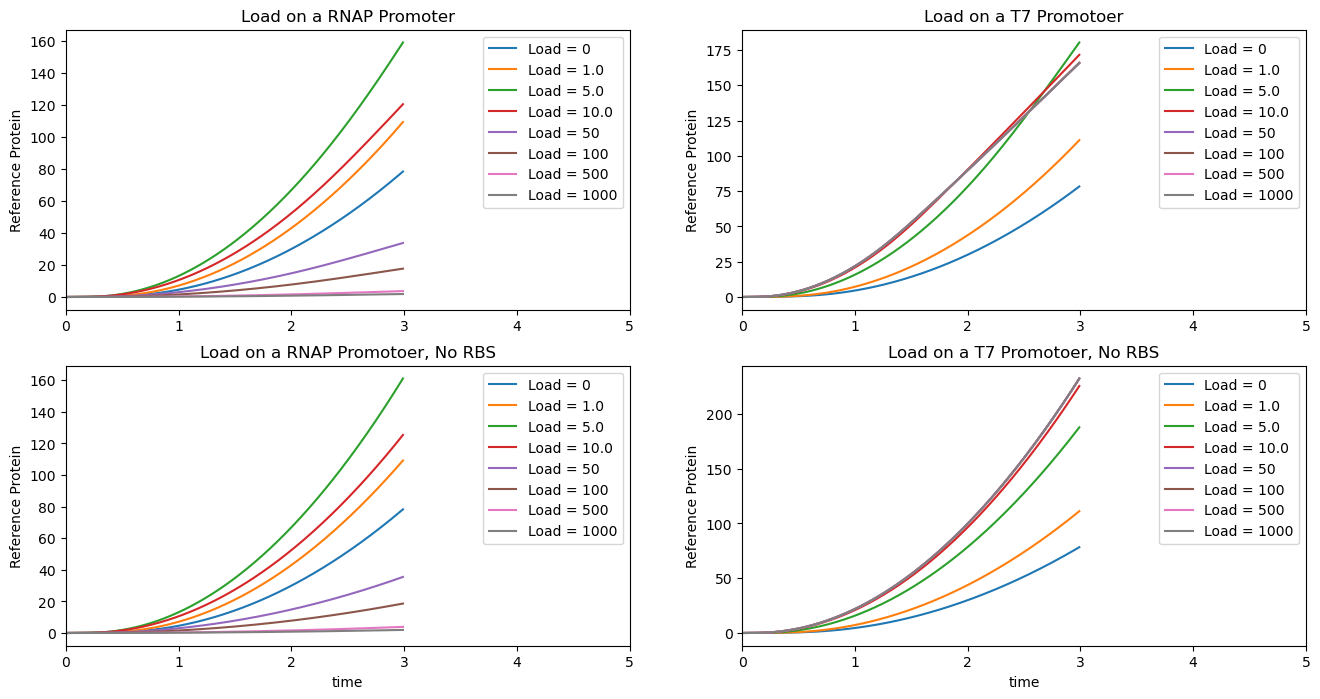

In [4]:
from biocrnpyler.components import Protein, Promoter
from biocrnpyler.mechanisms import Transcription_MM
#Because we are lazy, all parameters will use the default "param_name"-->value key mapping.
#Parameter warnings will be later suppressed in the Mixture constructor
#For details on how parameter loading and defaulting works, see the Parameter notebook.
kb, ku, ktx, ktl, kdeg = 100, 10, 3.0, 5.0, 2
parameters = {"kb":kb, "ku":ku, "ktx":ktx, "ktl":ktl, "kdeg":kdeg}

#A constituitively expressed reporter
#By default the promoter 'P' will use the polymerase 'rnap'
reference_assembly = DNAassembly(name = "ref", promoter = "P", rbs = "BCD")
#A constiuitively expressed load (RNA and Protein)
full_load_assembly = DNAassembly(name = "Load", promoter = "P", rbs = "BCD")
#A constiutively transcribed (but not translated) load
#By putting rbs = None, DNAassembly automatically knows not to include translation
RNA_load_assembly = DNAassembly(name = "TxLoad", promoter = "P", rbs = None)

#Load genes on orthogonal polymerases
T7 = Protein("T7") #Create a new protein (polymerase) called 'T7'

#Create a custom promoter with a custom mechanism that uses T7 instead of RNAP
#instantiate a new mechanism Transcription_MM with its own name and overwrote the default parameter rnap
mechanism_txt7 = Transcription_MM(name = "T7_transcription_mm", rnap=T7.get_species())
#Create an instance of a promoter with this mechanism for transcription
T7P = Promoter("T7P", mechanisms={"transcription":mechanism_txt7})
#Create A load assembly with the custom T7 promoter
T7_load_assembly = DNAassembly(name = "T7Load", promoter = T7P, rbs = "BCD")

#Each new assembly requires its own promoter instance - so here I create another here
T7P = Promoter("T7P", mechanisms={
    "transcription":Transcription_MM(name = "T7_transcription_mm", rnap=T7.get_species())})
#A load assembly with the custom T7 promoter and no RBS
T7RNA_load_assembly = DNAassembly(name = "T7TxLoad", promoter = T7P, rbs = None)

#Add all the assemblies to a mixture
components = [reference_assembly, full_load_assembly, T7_load_assembly, T7, RNA_load_assembly, T7RNA_load_assembly]
myMixture = TxTlExtract(name = "txtl", parameters = parameters, components = components)

#Print the CRN
myCRN = myMixture.compile_crn()

#The Species, Reaction, and CRN pretty_print functions return text which has been formated with a number of formatting options
print("\npretty_print gives a nicely formatted repesentation of the CRNS, reactions, and species. The names of species are formatted for clarity, but are not the actual species representations. Additionally a number of printing options are available.",
      "\n", myCRN.pretty_print(show_material = True, show_rates = True, show_attributes = True, show_keys = False))

#Simulate with BioSCRAPE if installed

print("Simulating")
try:
    %matplotlib inline
    import numpy as np
    import pylab as plt
    timepoints = np.arange(0, 3, .01)
    stochastic = False #Whether to use ODE models or Stochastic SSA models
    plt.figure(figsize = (16, 8))
    plt.subplot(221)
    plt.title("Load on a RNAP Promoter")
    loads = [0, 1.0, 5., 10., 50, 100, 500, 1000]
    for dna_Load in loads:
        #print("Simulating for dna_Load=", dna_Load)
        x0_dict = {"protein_T7": 10., "protein_RNAP":10., "protein_RNAase":5.0, "protein_Ribo":50.,
                   'dna_ref':5., 'dna_Load':dna_Load}

        results = myCRN.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0_dict, stochastic = stochastic)
        if results is not None:
            plt.plot(timepoints, results["protein_ref"], label = "Load = "+str(dna_Load))

    plt.xlim(0, 5)
    #plt.xlabel("time")
    plt.ylabel("Reference Protein")
    plt.legend()

    plt.subplot(222)
    plt.title("Load on a T7 Promotoer")
    for dna_Load in loads:
        #print("Simulating for dna_T7Load=", dna_Load)
        x0_dict = {"protein_T7": 10., "protein_RNAP":10., "protein_RNAase":5.0, "protein_Ribo":50.,
                   'dna_ref':5., 'dna_T7Load':dna_Load}
        results = myCRN.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0_dict, stochastic = stochastic)
        if results is not None:
            plt.plot(timepoints, results["protein_ref"], label="Load = " + str(dna_Load))
    plt.xlim(0, 5)
    #plt.xlabel("time")
    plt.ylabel("Reference Protein")
    plt.legend()

    plt.subplot(223)
    plt.title("Load on a RNAP Promotoer, No RBS")
    for dna_Load in loads:
        #print("Simulating for dna_TxLoad=", dna_Load)
        x0_dict = {"protein_T7": 10., "protein_RNAP":10., "protein_RNAase":5.0, "protein_Ribo":50.,
                   'dna_ref':5., 'dna_TxLoad':dna_Load}
        results = myCRN.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0_dict, stochastic = stochastic)
        if results is not None:
            plt.plot(timepoints, results["protein_ref"], label="Load = " + str(dna_Load))
    plt.xlim(0, 5)
    plt.xlabel("time")
    plt.ylabel("Reference Protein")
    plt.legend()

    plt.subplot(224)
    plt.title("Load on a T7 Promotoer, No RBS")
    for dna_Load in loads:
        #print("Simulating for dna_T7TxLoad=", dna_Load)
        x0_dict = {"protein_T7": 10., "protein_RNAP":10., "protein_RNAase":5.0, "protein_Ribo":50.,
                   'dna_ref':5., 'dna_T7TxLoad':dna_Load}
        results = myCRN.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0_dict, stochastic = stochastic)
        if results is not None:
            plt.plot(timepoints, results["protein_ref"], label="Load = " + str(dna_Load))
    plt.xlim(0, 5)
    plt.xlabel("time")
    plt.ylabel("Reference Protein")
    plt.legend()
    plt.show()
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')


In [ ]:
# End